#### **Objectives:**
1. To build a machine Learning classification model to determine wheather an individual will get a heart disease or not based on features such as:
<ul>
    <li>Age</li>
    <li>Chest pain type</li>
    <li>Maximum Heart Rate (Max HR)</li>
    <li>Cholesterol, etc</li>
</ul>

2. Apply label encoding to categorical features ie. norminal and ordinal variables
3. Analyze the effects of Principal Component Analysis (PCA), Scaling of samples, oulier removal etc on the efficiency of the model
4. Apply cross validation and grid search on "pycaret's", Auto Ml top three supervised classification models
5. Save the model on a pickle file for deployment
6. Build a machine learning app using Streamlit's API for Heart Disease Prediction on th server


In [504]:
#Import all necessary libraries
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import IPython
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
os.listdir()

['classification.ipynb', 'dataset.csv']

In [6]:
# Loading the dataset
data = pd.read_csv('dataset.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#### Exploratory Data Analysis

In [8]:
data.shape

(918, 12)

In [173]:
def NumberOfColumns(df): 
    for number, names in enumerate(data.columns):
        count = print(number, names)
    print(f'The shape of the data is: ',df.shape)
       

In [174]:
NumberOfColumns(df=data)

0 Age
1 Sex
2 ChestPainType
3 RestingBP
4 Cholesterol
5 FastingBS
6 RestingECG
7 MaxHR
8 ExerciseAngina
9 Oldpeak
10 ST_Slope
11 HeartDisease
The shape of the data is:  (918, 12)


In [175]:
data.isnull().any()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [29]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Encoding of categorical variables

In [300]:
categorical_features = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']
categorical_features_dataframe = data[categorical_features]
categorical_features_dataframe.ChestPainType.value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [299]:
ordinal_categorical_features = categorical_features_dataframe[['FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
ordinal_categorical_features.head()

,FastingBS,RestingECG,ExerciseAngina,ST_Slope
0,0,Normal,N,Up
1,0,Normal,N,Flat
2,0,ST,N,Up
3,0,Normal,Y,Flat
4,0,Normal,N,Up


In [50]:
#Label Encoding

ordinal_categorical_features.replace(
    {
        'RestingECG':{
            'Normal': 1,
            'LVH':2,
            'ST':3
        },
        'ExerciseAngina':{
            'N':0,
            'Y':1
        },
        'ST_Slope':{
            'Flat': 1,
            'Up': 2,
            'Down':3
        }
    }, inplace=True
)

ordinal_categorical_features.head()

,FastingBS,RestingECG,ExerciseAngina,ST_Slope
0,0,1,0,2
1,0,1,0,1
2,0,3,0,2
3,0,1,1,1
4,0,1,0,2


In [86]:
norminal_categorical_features = categorical_features_dataframe[['Sex','ChestPainType']]
norminal_categorical_features.head()

,Sex,ChestPainType
0,M,ATA
1,F,NAP
2,M,ATA
3,F,ASY
4,M,NAP


In [89]:
# Applying one hot encoding to norminal categorical features
dummies = pd.get_dummies(norminal_categorical_features[['Sex','ChestPainType']], drop_first=True)
dummies.head()


,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,1,1,0,0
1,0,0,1,0
2,1,1,0,0
3,0,0,0,0
4,1,0,1,0


In [107]:
# Concatenating ordinal and norminal categorical features
concate = pd.concat([dummies,ordinal_categorical_features], axis=1)
concate.head()

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS,RestingECG,ExerciseAngina,ST_Slope
0,1,1,0,0,0,1,0,2
1,0,0,1,0,0,1,0,1
2,1,1,0,0,0,3,0,2
3,0,0,0,0,0,1,1,1
4,1,0,1,0,0,1,0,2


In [112]:
numerical_variables = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
numerical_variables = data[numerical_variables]
numerical_variables.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,40,140,289,172,0.0
1,49,160,180,156,1.0
2,37,130,283,98,0.0
3,48,138,214,108,1.5
4,54,150,195,122,0.0


In [221]:
final_categorical_variable_concatenation = pd.concat([numerical_variables,concate], axis=1)
final_categorical_variable_concatenation.head()
final_categorical_variable_concatenation['target'] = data['HeartDisease']

#### Scaling and Oulier Removal


In [238]:
final_categorical_variable_concatenation.describe().iloc[:,0:7]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364,0.789760,0.188453
std,9.432617,18.514154,109.384145,25.460334,1.066570,0.407701,0.391287
min,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,47.000000,120.000000,173.250000,120.000000,0.000000,1.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000,1.000000,0.000000
75%,60.000000,140.000000,267.000000,156.000000,1.500000,1.000000,0.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,1.000000,1.000000


In [239]:
final_categorical_variable_concatenation.describe().iloc[:,8:]


,ChestPainType_TA,FastingBS,RestingECG,ExerciseAngina,ST_Slope,target
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.050109,0.233115,1.592593,0.404139,1.567538,0.553377
std,0.218289,0.423046,0.793670,0.490992,0.618959,0.497414
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,2.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,3.000000,1.000000


In [246]:
# scaling the features for uniform distribution

scaled_X = skl.preprocessing.StandardScaler().fit_transform(final_categorical_variable_concatenation)
scaled_X = pd.DataFrame(scaled_X, columns=final_categorical_variable_concatenation.columns)
scaled_X.head().iloc[:,0:7]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,0.515952,2.075177
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,-1.938163,-0.481887
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,0.515952,2.075177
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,-1.938163,-0.481887
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,0.515952,-0.481887


In [248]:
scaled_X.head().iloc[:,7:]

,ChestPainType_NAP,ChestPainType_TA,FastingBS,RestingECG,ExerciseAngina,ST_Slope,target
0,-0.532838,-0.229679,-0.551341,-0.747055,-0.823556,0.699073,-1.113115
1,1.876744,-0.229679,-0.551341,-0.747055,-0.823556,-0.917423,0.898380
2,-0.532838,-0.229679,-0.551341,1.774257,-0.823556,0.699073,-1.113115
3,-0.532838,-0.229679,-0.551341,-0.747055,1.214246,-0.917423,0.898380
4,1.876744,-0.229679,-0.551341,-0.747055,-0.823556,0.699073,-1.113115


In [249]:
# Outlier removal using quartile and interquartile range
def outlier_removal(df, Age,RestingBP,Cholesterol,MaxHR,Oldpeak):
    Q1_Age = df[Age].quantile(0.25)
    Q3_Age = df[Age].quantile(0.75)
    IQR_Age = Q3_Age-Q1_Age
    lower_limit_1 = Q1_Age - 1.5 * IQR_Age
    upper_limit_1 = Q3_Age + 1.5 * IQR_Age
    Q1_RestingBP = df[RestingBP].quantile(0.25)
    Q3_RestingBP = df.RestingBP.quantile(0.75)
    IQR_RestingBP = Q3_RestingBP-Q1_RestingBP
    lower_limit_2 = Q1_RestingBP - 1.5 * IQR_RestingBP
    upper_limit_2 = Q3_RestingBP + 1.5 * IQR_RestingBP
    Q1_Cholesterol = df.Cholesterol.quantile(0.25)
    Q3_Cholesterol= df.Cholesterol.quantile(0.75)
    IQR_Cholesterol = Q3_Cholesterol-Q1_Cholesterol
    lower_limit_3 = Q1_Cholesterol - 1.5 * IQR_Cholesterol
    upper_limit_3 = Q3_Cholesterol + 1.5 * IQR_Cholesterol
    Q1_MaxHR = df[MaxHR].quantile(0.25)
    Q3_MaxHR= df[MaxHR].quantile(0.75)
    IQR_MaxHR = Q3_MaxHR-Q1_MaxHR
    lower_limit_4 = Q1_MaxHR - 1.5 * IQR_MaxHR
    upper_limit_4 = Q3_MaxHR + 1.5 * IQR_MaxHR
    Q1_Oldpeak = df[Oldpeak].quantile(0.25)
    Q3_Oldpeak= df[Oldpeak].quantile(0.75)
    IQR_Oldpeak = Q3_Oldpeak-Q1_Oldpeak
    lower_limit_5 = Q1_Oldpeak - 1.5 * IQR_Oldpeak
    upper_limit_5 = Q3_Oldpeak + 1.5 * IQR_Oldpeak
    df_1 = df[(df[Age] < upper_limit_1) & (df[Age] > lower_limit_1)]
    df_2 = df_1[(df[RestingBP] < upper_limit_2) & (df[RestingBP] > lower_limit_2)]
    df_3 = df_2[(df[Cholesterol] < upper_limit_3) & (df[Cholesterol] > lower_limit_3)]
    df_4 = df_3[(df[MaxHR] < upper_limit_4) & (df[MaxHR] > lower_limit_4)]
    df_final = df_4[(df[Oldpeak] < upper_limit_5) & (df[Oldpeak] > lower_limit_5)]
    return df_final




In [250]:
NumberOfColumns(df = scaled_X)

0 Age
1 Sex
2 ChestPainType
3 RestingBP
4 Cholesterol
5 FastingBS
6 RestingECG
7 MaxHR
8 ExerciseAngina
9 Oldpeak
10 ST_Slope
11 HeartDisease
The shape of the data is:  (918, 14)


In [406]:
removed_outlier = outlier_removal(df=final_categorical_variable_concatenation,Age='Age',
RestingBP='RestingBP'
,Cholesterol='Cholesterol',MaxHR='MaxHR',Oldpeak='Oldpeak')

In [326]:
NumberOfColumns(removed_outlier)

0 Age
1 Sex
2 ChestPainType
3 RestingBP
4 Cholesterol
5 FastingBS
6 RestingECG
7 MaxHR
8 ExerciseAngina
9 Oldpeak
10 ST_Slope
11 HeartDisease
The shape of the data is:  (690, 14)


In [327]:
number_of_outlier_removed = data.shape[0] - removed_outlier.shape[0]
print(f'The total number of removed outliers are: ', number_of_outlier_removed)

The total number of removed outliers are:  228


#### Data Visualization

In [328]:
numerical_variables_removed_outlier = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
numerical_variables_for_plotting = removed_outlier[numerical_variables_removed_outlier]
numerical_variables_for_plotting

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,40,140,289,172,0.0
1,49,160,180,156,1.0
2,37,130,283,98,0.0
3,48,138,214,108,1.5
4,54,150,195,122,0.0
...,...,...,...,...,...
913,45,110,264,132,1.2
914,68,144,193,141,3.4
915,57,130,131,115,1.2
916,57,130,236,174,0.0


In [329]:
def distp_plot(df):
    for col in df.columns:
        plt.figure(figsize=(10,5))
        plt.subplot(1,1,1)
        sns.distplot(df[col])
        plt.show()
def box_plot(df):
    for col in df.columns:
        plt.figure(figsize=(10,5))
        plt.subplot(1,1,1)
        sns.boxplot(df[col])
        plt.show()

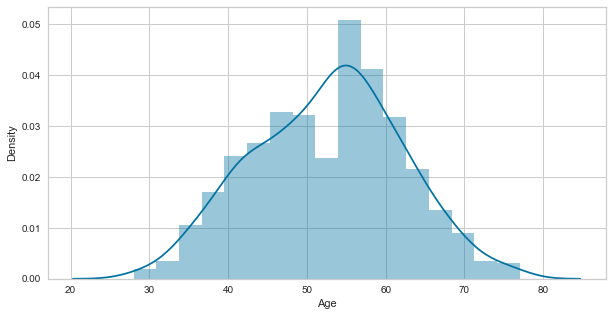

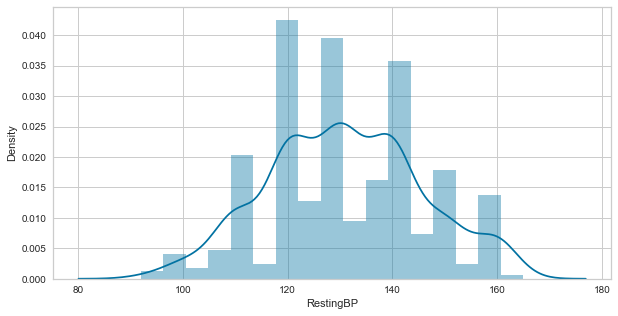

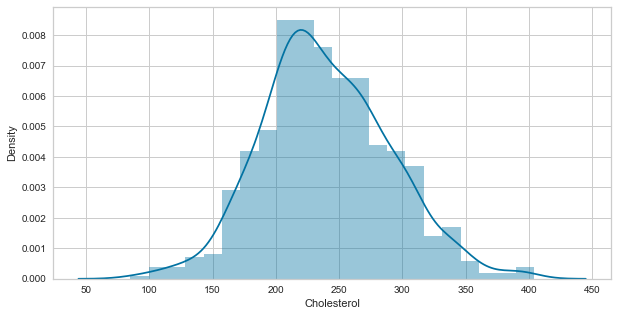

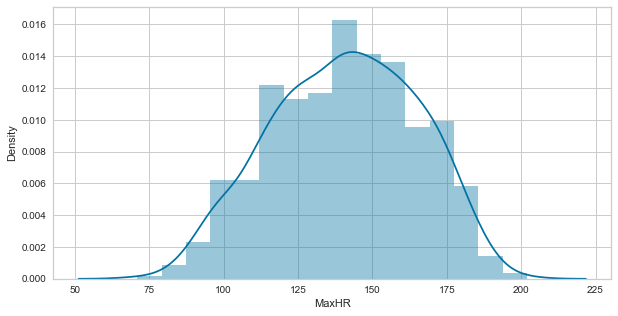

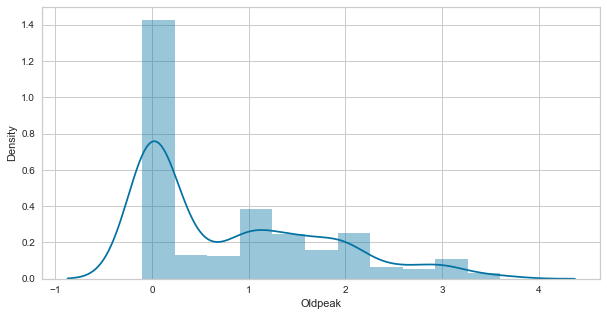

In [330]:
distp_plot(numerical_variables_for_plotting)

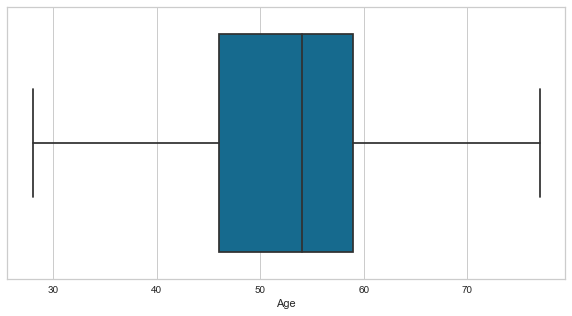

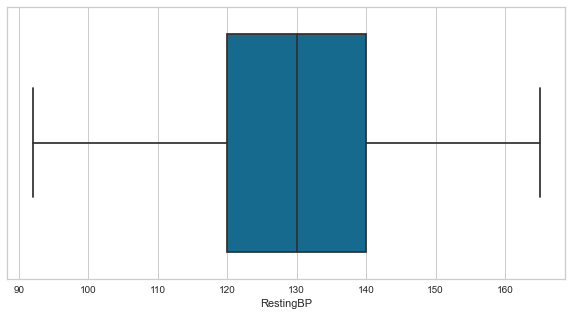

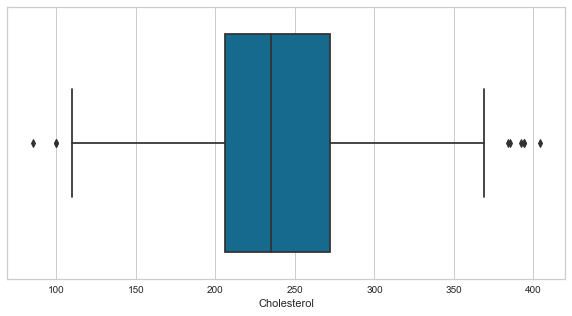

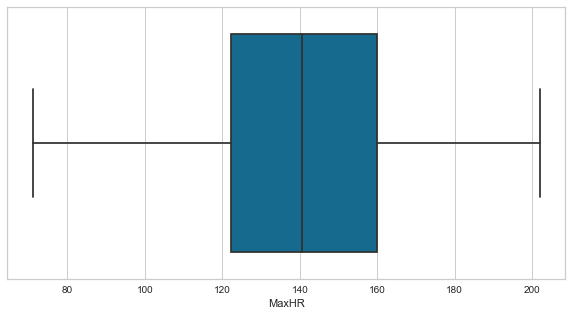

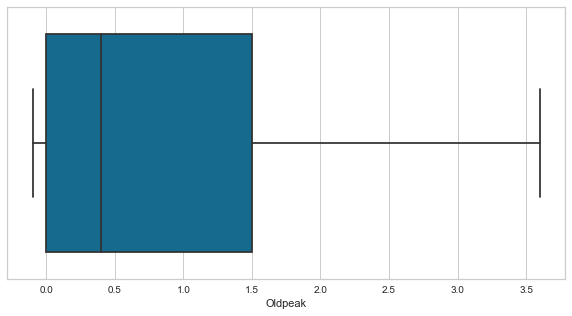

In [331]:
box_plot(numerical_variables_for_plotting)

In [412]:
removed_outlier.iloc[:,0:7]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA
0,40,140,289,172,0.0,1,1
1,49,160,180,156,1.0,0,0
2,37,130,283,98,0.0,1,1
3,48,138,214,108,1.5,0,0
4,54,150,195,122,0.0,1,0
...,...,...,...,...,...,...,...
913,45,110,264,132,1.2,1,0
914,68,144,193,141,3.4,1,0
915,57,130,131,115,1.2,1,0
916,57,130,236,174,0.0,0,1


In [413]:
removed_outlier.iloc[:,8:]


,ChestPainType_TA,FastingBS,RestingECG,ExerciseAngina,ST_Slope,target
0,0,0,1,0,2,0
1,0,0,1,0,1,1
2,0,0,3,0,2,0
3,0,0,1,1,1,1
4,0,0,1,0,2,0
...,...,...,...,...,...,...
913,1,0,1,0,1,1
914,0,1,1,0,1,1
915,0,0,1,1,1,1
916,0,0,2,0,1,1


### Checking for correlation among variables

In [495]:
correlation = removed_outlier.corr()

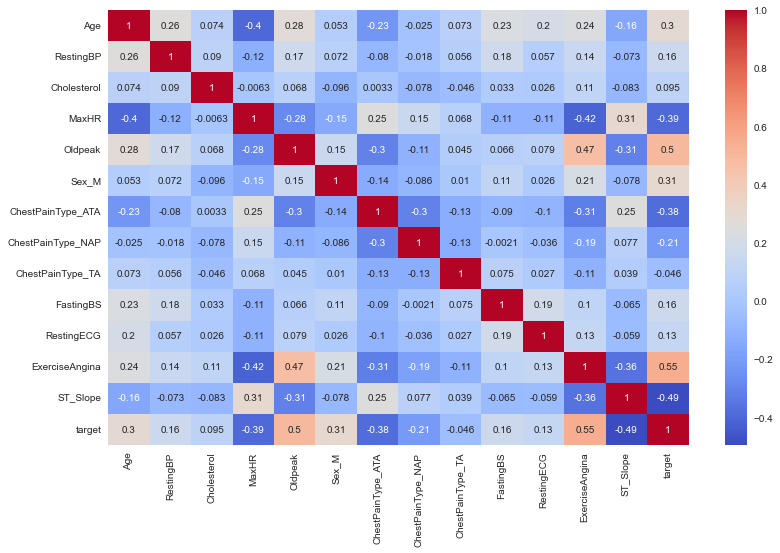

In [497]:
plt.figure(figsize=(13,8))
sns.heatmap(correlation, cmap='coolwarm', annot=True)

plt.show()

In [502]:
correlation.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_M',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'target'],
      dtype='object')

<Figure size 1296x864 with 0 Axes>

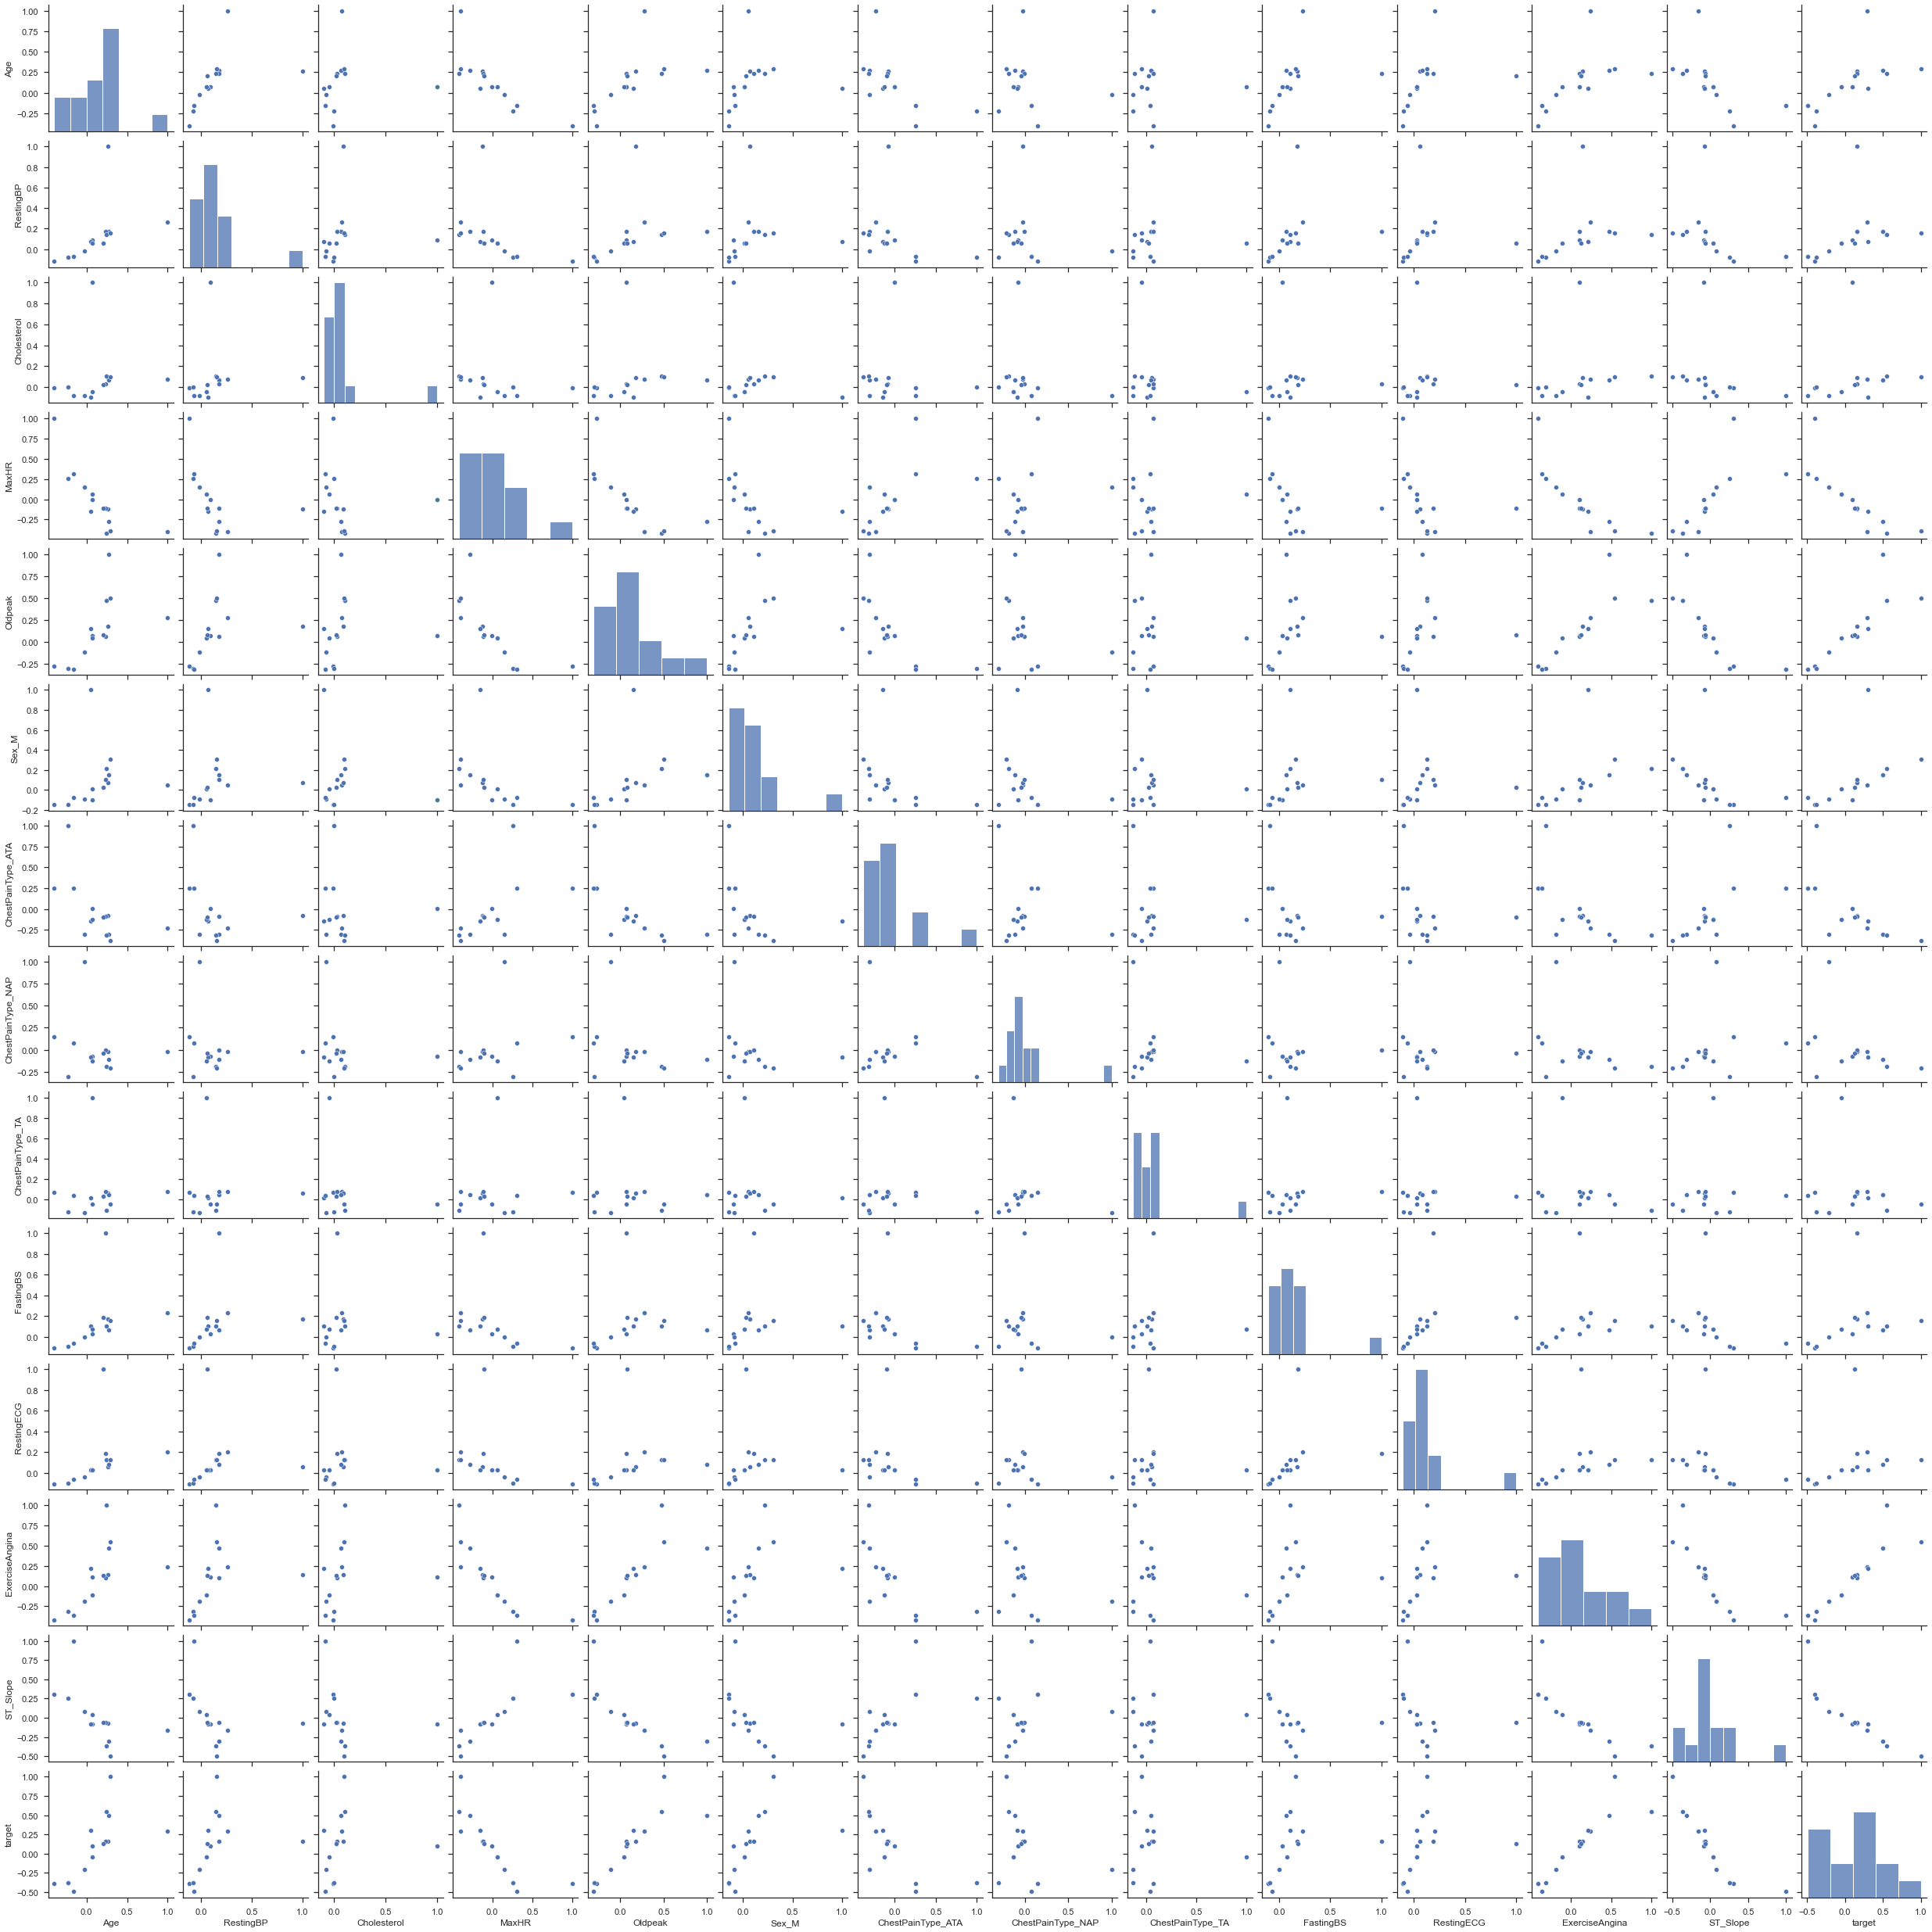

In [503]:
plt.figure(figsize=(18,12))
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(correlation)
plt.show()

### Load Pycaret's top 2 model after AutoML

In [385]:
gradient_boosting = joblib.load('gbc_model.pkl')
light_boosting = joblib.load('lgb_model.pkl')

In [386]:
print(joblib.load('gbc_model.pkl'))
print(joblib.load('lgb_model.pkl'))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=1,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=280,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=6616, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
LGBMClassifier(bagging_fraction=0.7, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=11, min_child_weight=0.001, min_split_gain=

### Training the model

In [370]:
X = removed_outlier.drop('target', axis=1)
y = removed_outlier.target

In [373]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [390]:
light_boosting

LGBMClassifier(bagging_fraction=0.7, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=11, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=190, n_jobs=-1, num_leaves=2, objective=None,
               random_state=6616, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [392]:
cross_validation_LGBMClassifier = skl.model_selection.cross_val_score(light_boosting,X_train,y_train, cv = 5)
cross_validation_LGBMClassifier.mean()

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 

0.8549555867227676

In [393]:
cross_validation_GradientBoostingClassifier= skl.model_selection.cross_val_score(gradient_boosting,X_train,y_train, cv = 5)
cross_validation_GradientBoostingClassifier.mean()

0.8679756895745676

In [397]:
manual_random_forest_model = skl.ensemble.RandomForestClassifier()
manual_random_forest_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [398]:
cross_validation_RandomForestClassifier= skl.model_selection.cross_val_score(manual_random_forest_model,X_train,y_train, cv = 5)
cross_validation_RandomForestClassifier.mean()

0.8571528751753157

### Validation

In [401]:
## From the above cross validation scores, the model to be use is gradient_boosting
gradient_boosting

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=1,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=280,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=6616, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Model Training

In [403]:
trained_model = gradient_boosting.fit(X_train,y_train)

In [404]:
trained_model.score(X_train,y_train)

0.8896103896103896

In [405]:
trained_model.score(X_test,y_test)

0.8596491228070176

In [416]:
predicted_y = trained_model.predict(X_test)
predicted_y

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0], dtype=int64)

In [431]:
cmx = skl.metrics.confusion_matrix(y_test,predicted_y)
cmx = pd.DataFrame(cmx)

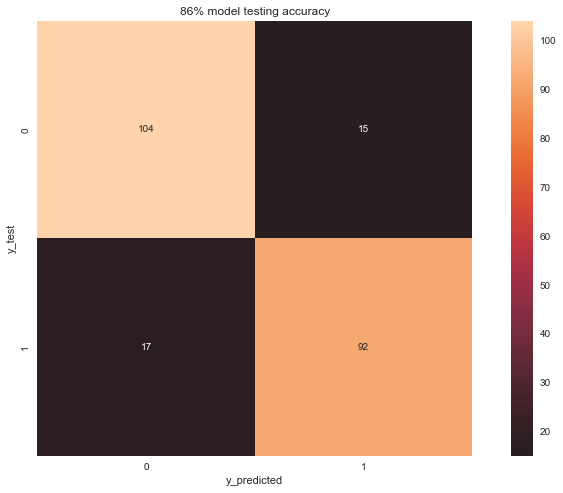

In [443]:
plt.figure(figsize=(14,8))
sns.heatmap(cmx, annot=True, square=True, center=10,fmt='d')
plt.ylabel('y_test')
plt.xlabel('y_predicted')
plt.title('86% model testing accuracy')
plt.show()

### You can run shapest module app to have a visualization of how the model is working
#### Here is a snippet of the features importance from shapash

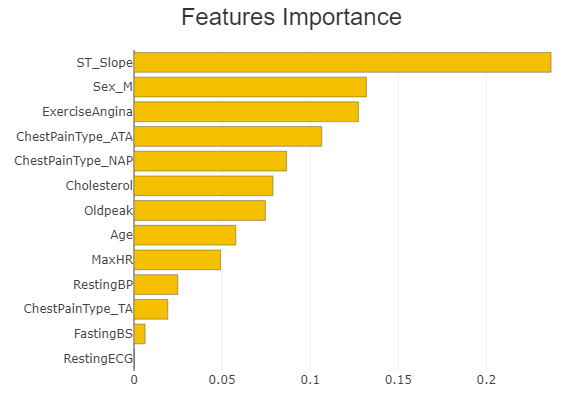

In [512]:
img = IPython.display.Image('feature_importance_from shapash.png')
img

In [445]:
X_train.to_csv('tained_data.csv')

In [446]:
X_train.head(2)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS,RestingECG,ExerciseAngina,ST_Slope
586,53,124,243,122,2.0,1,0,0,0,0,1,1,1
147,43,120,249,176,0.0,0,1,0,0,0,3,0,2


In [453]:
X_test

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS,RestingECG,ExerciseAngina,ST_Slope,predicted_testing_values
452,60,140,281,118,1.5,1,0,0,0,0,3,1,1,1
722,60,150,258,157,2.6,0,0,0,0,0,2,0,1,1
279,54,130,253,155,0.0,0,1,0,0,0,3,0,2,0
533,63,110,252,140,2.0,1,0,0,0,0,3,1,1,1
511,63,160,267,88,2.0,1,0,0,0,1,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,57,156,173,119,3.0,1,0,0,0,0,2,1,3,1
252,61,125,292,115,0.0,1,0,0,0,0,3,1,2,1
867,44,112,290,153,0.0,1,0,0,0,0,2,0,2,0
416,63,140,260,112,3.0,1,0,0,0,0,3,1,1,1


In [480]:
final_test_dataframe = X_test.copy()
final_test_dataframe =  final_test_dataframe.reset_index()
final_test_dataframe.drop('index',axis=1, inplace=True)
final_test_dataframe.head()


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS,RestingECG,ExerciseAngina,ST_Slope
0,60,140,281,118,1.5,1,0,0,0,0,3,1,1
1,60,150,258,157,2.6,0,0,0,0,0,2,0,1
2,54,130,253,155,0.0,0,1,0,0,0,3,0,2
3,63,110,252,140,2.0,1,0,0,0,0,3,1,1
4,63,160,267,88,2.0,1,0,0,0,1,3,1,1


In [481]:
trained_model.predict([[24,145,400,122,3,1,1,0,0,0,2,1,1]])

array([1], dtype=int64)

In [482]:
probability_of_heart_disease = trained_model.predict_proba(X_test)
probability_of_heart_disease = pd.DataFrame(probability_of_heart_disease,columns=
['Prob will not get HD','Prob will get HD'])
probability_of_heart_disease

,Prob will not get HD,Prob will get HD
0,0.023480,0.976520
1,0.286877,0.713123
2,0.976796,0.023204
3,0.037387,0.962613
4,0.014903,0.985097
...,...,...
223,0.102213,0.897787
224,0.276439,0.723561
225,0.781585,0.218415
226,0.018148,0.981852


In [488]:
together = pd.concat([final_test_dataframe, probability_of_heart_disease], axis=1)
together.iloc[:,0:8]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP
0,60,140,281,118,1.5,1,0,0
1,60,150,258,157,2.6,0,0,0
2,54,130,253,155,0.0,0,1,0
3,63,110,252,140,2.0,1,0,0
4,63,160,267,88,2.0,1,0,0
...,...,...,...,...,...,...,...,...
223,57,156,173,119,3.0,1,0,0
224,61,125,292,115,0.0,1,0,0
225,44,112,290,153,0.0,1,0,0
226,63,140,260,112,3.0,1,0,0


In [489]:
together.iloc[:,9:]

,FastingBS,RestingECG,ExerciseAngina,ST_Slope,Prob will not get HD,Prob will get HD
0,0,3,1,1,0.023480,0.976520
1,0,2,0,1,0.286877,0.713123
2,0,3,0,2,0.976796,0.023204
3,0,3,1,1,0.037387,0.962613
4,1,3,1,1,0.014903,0.985097
...,...,...,...,...,...,...
223,0,2,1,3,0.102213,0.897787
224,0,3,1,2,0.276439,0.723561
225,0,2,0,2,0.781585,0.218415
226,0,3,1,1,0.018148,0.981852


In [493]:
report_matrice = skl.metrics.classification_report(y_test,predicted_y,output_dict=True)
report_matrice = pd.DataFrame(report_matrice)
report_matrice.head()

,0,1,accuracy,macro avg,weighted avg
precision,0.859504,0.859813,0.859649,0.859659,0.859652
recall,0.873950,0.844037,0.859649,0.858993,0.859649
f1-score,0.866667,0.851852,0.859649,0.859259,0.859584
support,119.000000,109.000000,0.859649,228.000000,228.000000


## **Final Conclusion** 
1. Develop a streamlit App to run the model on a server
2. Thank God for a successful work done